This is a duplicate of notebook `1_data_preparation`, that aims to stratify the splits also in the `primary` field.

In [2]:
import json

dataset_path = "/home/peterr/macocu/task5_webgenres/data/original/dataset/dataset.json"

with open(dataset_path, "r") as f:
    dataset = json.load(f)


In [3]:
len(dataset)

1002

# Downsampling rare labels

Rarely occuring primary and secondary labels will be changed as per `Dictionaries_for_genre_mapping.py`:

In [4]:
# First step - categories with less than 5 examples are merged with other categories:
first = {"Script/Drama":"Other", "Lyrical":"Other","FAQ":"Other"}

# Second step - categories (marked by the arrow in the hierarchy figure) are merged with similar categories:
# second = {"Recipe":"Instruction", "Research Article":"Information/Explanation", "Review":"Opinion/Argumentation", "Promotion of Services":"Promotion", "Promotion of a Product":"Promotion", "Invitation":"Promotion"}
second = dict()

In [5]:
change_counter = 0
for i, document in enumerate(dataset):
    primary = document["primary"]
    secondary = document["secondary"]

    if primary in first.keys():
        #print(f"Changing primary from {primary} to {first[primary]}")
        document["primary"] = first[primary]
        change_counter += 1
        
    if secondary in first.keys():
        #print(f"Changing secondary from {secondary} to {first[secondary]}")
        document["secondary"] = first[secondary]
        change_counter += 1

    if primary in second.keys():
        #print(f"Changing primary from {primary} to {second[primary]}")
        document["primary"] = second[primary]
        change_counter += 1

    if secondary in second.keys():
        #print(f"Changing secondary from {secondary} to {second[secondary]}")
        document["secondary"] = second[secondary]
        change_counter += 1

    dataset[i] = document
change_counter

8

In total 8 changes were made.

Next: domains will be extracted from urls and saved in the dataset.

In [6]:
import parse

pattern = "{protocol}://{domain}/{rest}"
p = parse.compile(pattern)

modified_pattern = "{protocol}://{domain}/"
mp = parse.compile(modified_pattern)
for document in dataset:
    parse_result = p.parse(document["url"])
    try:
        document["domain"] = parse_result["domain"]
    except TypeError:
        parse_result = mp.parse(document["url"])
        document["domain"] = parse_result["domain"]


# Transforming the dataset in tabular form

In [9]:
fields = dataset[0].keys()
fields

dict_keys(['id', 'url', 'crawled', 'primary', 'secondary', 'tertiary', 'hard', 'paragraphs', 'domain'])

In [10]:
tabular_dataset = dict()
for field in fields:
    tabular_dataset[field] = [item[field] for item in dataset]
tabular_dataset["stratum"] = [item["primary"]for item in dataset]

In [12]:
import pandas as pd

df = pd.DataFrame(data=tabular_dataset)
interim_dir = "/home/peterr/macocu/task5_webgenres/data/interim"
df.to_csv(interim_dir+"/tabular_2c.csv", index=False)


In [13]:
df.stratum.unique()

array(['News/Reporting', 'Information/Explanation',
       'Promotion of Services', 'Opinionated News',
       'Promotion of a Product', 'Invitation', 'Legal/Regulation',
       'Forum', 'Opinion/Argumentation', 'Other', 'Announcement',
       'Instruction', 'Research Article', 'List of Summaries/Excerpts',
       'Correspondence', 'Promotion', 'Recipe', 'Review', 'Prose', 'Call',
       'Interview'], dtype=object)

In [14]:
nr_of_domains = df.domain.shape[0]
nr_of_unique_domains = len(df.domain.unique())
print("Unique domains: ", nr_of_unique_domains, " out of ", nr_of_domains)

Unique domains:  721  out of  1002


In [15]:
df["domain_unique"] = False
for domain in df.domain.unique():
    subset = df.loc[df.domain == domain,:]
    if len(subset) == 1:
        df.loc[df.domain == domain, "domain_unique"] = True

# Splitting:

In [127]:
from sklearn.model_selection import train_test_split

train, devtest = train_test_split(df, test_size=0.2, stratify=df.stratum, random_state=44)

In [128]:
bydomain = df.groupby("domain").count()["id"]
problematic_domains = bydomain[bydomain != 1]

In [129]:
for i, domain in enumerate(problematic_domains.index):
    if domain in train.domain.unique() and domain in devtest.domain.unique():
        #print(f"Domain {domain} found in both!", end=" ")
        pass
    else:
        continue
    if i%5 == 0:
        indices_to_transfer_to_devtest = train.domain == domain
        devtest = pd.concat([devtest, train[indices_to_transfer_to_devtest]], ignore_index=True)
        train = train[~indices_to_transfer_to_devtest]
    else:
        indices_to_transfer_to_train = devtest.domain == domain
        train = pd.concat([train, devtest[indices_to_transfer_to_train]], ignore_index=True)
        devtest = devtest[~indices_to_transfer_to_train]
    devtest.reset_index(drop=True, inplace=True)
    train.reset_index(drop=True, inplace=True)
    

In [130]:
train.shape[0], devtest.shape[0]

(824, 178)

In [131]:
train.shape[0]/(train.shape[0]+devtest.shape[0])

0.8223552894211577

In [132]:
for i, domain in enumerate(problematic_domains.index):
    if domain in train.domain.unique() and domain in devtest.domain.unique():
        print(f"Domain {domain} found in both!")

Notice how this produced no hits.

![Good, good](http://www.quickmeme.com/img/5e/5eff1c377f48790ca75a9a9878660481eeb4fde0172a2ad49505dc15890486c8.jpg)

Moving on, we still have to perform the same splitting on dev and test data:

In [154]:
dev, test = train_test_split(devtest, test_size=0.5, stratify=devtest.crawled, random_state=45)

bydomain = devtest.groupby("domain").count()["id"]
problematic_domains = bydomain[bydomain != 1]

In [134]:
for i, domain in enumerate(problematic_domains.index):
    if domain in test.domain.unique() and domain in dev.domain.unique():
        print(f"Domain {domain} found in both!", end=" ")
    else:
        continue
    if i%2 != 0:
        indices_to_transfer_to_dev = test.domain == domain
        dev = pd.concat([dev, test[indices_to_transfer_to_dev]], ignore_index=True)
        test = test[~indices_to_transfer_to_dev]
    else:
        indices_to_transfer_to_test = dev.domain == domain
        test = pd.concat([test, dev[indices_to_transfer_to_test]], ignore_index=True)
        dev = dev[~indices_to_transfer_to_test]
    dev.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)

Domain ars.rtvslo.si found in both! Domain konji.si found in both! Domain www.24ur.com found in both! Domain www.delovno-pravo.si found in both! Domain www.ecco-verde.si found in both! Domain www.gov.si found in both! Domain www.miroslav-vilhar.si found in both! Domain www.mojmuffin.si found in both! Domain www.radiocelje.si found in both! Domain www.saiorg.si found in both! Domain www.studentska-trgovina.si found in both! Domain www.zurnal24.si found in both! 

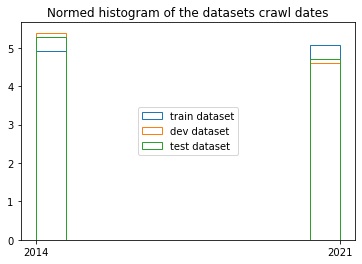

In [155]:
density = True

plt.hist(train.crawled, label="train dataset", density=density, histtype="step")
plt.hist(dev.crawled, label="dev dataset", density=density, histtype="step")
plt.hist(test.crawled, label="test dataset", density=density, histtype="step")
plt.legend(loc="center")
plt.title("Normed histogram of the datasets crawl dates")
plt.savefig("images/2c_crawled.png")
plt.show()

In [156]:
bydomain = df.groupby("domain").count()["id"]
problematic_domains = bydomain[bydomain != 1]

for i, domain in enumerate(problematic_domains.index):
    is_in_train = domain in train.domain.unique()
    is_in_dev = domain in dev.domain.unique()
    is_in_test = domain in test.domain.unique()
    if sum([is_in_train, is_in_dev, is_in_test]) > 1:
        print(f"Domain {domain} found in more than one split!")

Domain ars.rtvslo.si found in more than one split!
Domain dne.enaa.com found in more than one split!
Domain metinalista.si found in more than one split!
Domain old.radiostudent.si found in more than one split!
Domain www.24ur.com found in more than one split!
Domain www.atr.si found in more than one split!
Domain www.ecco-verde.si found in more than one split!
Domain www.gov.si found in more than one split!
Domain www.miroslav-vilhar.si found in more than one split!
Domain www.mojmuffin.si found in more than one split!
Domain www.narodnjak.si found in more than one split!
Domain www.radiocelje.si found in more than one split!
Domain www.spins.si found in more than one split!
Domain www.studentska-trgovina.si found in more than one split!
Domain www.viva.si found in more than one split!
Domain www.zurnal24.si found in more than one split!


In [157]:
# import os

# interim_dir = "/home/peterr/macocu/task5_webgenres/data/interim"

# train.to_csv(os.path.join(interim_dir, "train_2c.csv"), index=False)
# test.to_csv(os.path.join(interim_dir, "test_2c.csv"), index=False)
# dev.to_csv(os.path.join(interim_dir, "dev_2c.csv"), index=False)

Let's check how the ratios of hardness and primary labels look like across the three splits:

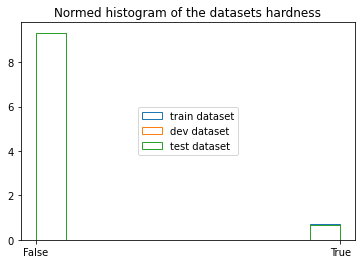

In [158]:
density = True

plt.hist(train.hard.apply(lambda b: str(b)), label="train dataset", density=density, histtype="step")
plt.hist(dev.hard.apply(lambda b: str(b)), label="dev dataset", density=density, histtype="step")
plt.hist(test.hard.apply(lambda b: str(b)), label="test dataset", density=density, histtype="step")
plt.legend(loc="center")
plt.title("Normed histogram of the datasets hardness")
plt.savefig("images/2c_hardness.png")
plt.show()

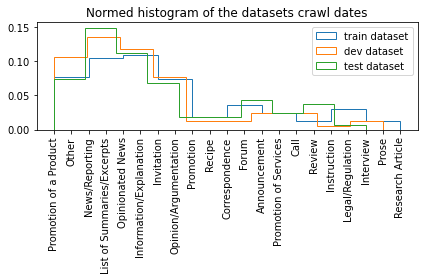

In [159]:
%matplotlib inline

density = True

plt.hist(train.primary, label="train dataset", density=density, histtype="step")
plt.hist(dev.primary, label="dev dataset", density=density, histtype="step")
plt.hist(test.primary, label="test dataset", density=density, histtype="step")
plt.legend()
plt.title("Normed histogram of the datasets crawl dates")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("images/2c_primaries.png")
plt.show()

In [162]:
primaries = "Instruction,Legal/Regulation,Interview,Prose,Research Article".split(",")
for primary in primaries:
    print(primary, df[df.primary == primary].shape[0])

Instruction 38
Legal/Regulation 17
Interview 8
Prose 6
Research Article 9


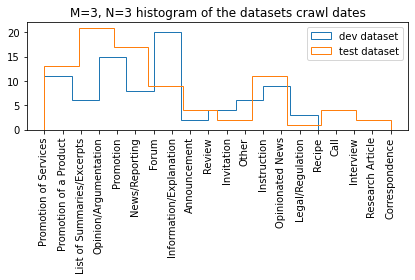

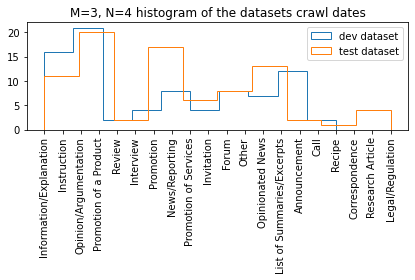

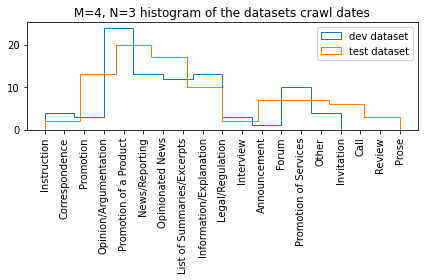

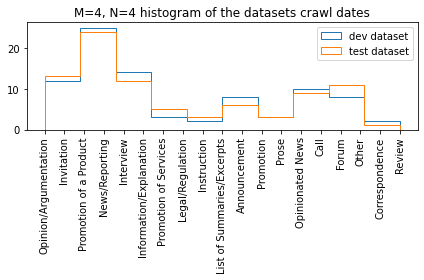

In [189]:
def split(M, N):
    from sklearn.model_selection import train_test_split

    train, devtest = train_test_split(df, test_size=0.2, stratify=df.primary, random_state=M)

    bydomain = df.groupby("domain").count()["id"]
    problematic_domains = bydomain[bydomain != 1]

    for i, domain in enumerate(problematic_domains.index):
        if domain in train.domain.unique() and domain in devtest.domain.unique():
            #print(f"Domain {domain} found in both!", end=" ")
            pass
        else:
            continue
        if i%5 == 0:
            indices_to_transfer_to_devtest = train.domain == domain
            devtest = pd.concat([devtest, train[indices_to_transfer_to_devtest]], ignore_index=True)
            train = train[~indices_to_transfer_to_devtest]
        else:
            indices_to_transfer_to_train = devtest.domain == domain
            train = pd.concat([train, devtest[indices_to_transfer_to_train]], ignore_index=True)
            devtest = devtest[~indices_to_transfer_to_train]
        devtest.reset_index(drop=True, inplace=True)
        train.reset_index(drop=True, inplace=True)
    for i, domain in enumerate(problematic_domains.index):
        if domain in train.domain.unique() and domain in devtest.domain.unique():
            print(f"Domain {domain} found in both!")

    dev, test = train_test_split(devtest, test_size=0.5, 
                                # stratify=devtest.primary, 
                                random_state=N)

    # bydomain = devtest.groupby("domain").count()["id"]
    # problematic_domains = bydomain[bydomain != 1]
    # 
    # for i, domain in enumerate(problematic_domains.index):
    #     if domain in test.domain.unique() and domain in dev.domain.unique():
    #         print(f"Domain {domain} found in both!", end=" ")
    #     else:
    #         continue
    #     if i%2 != 0:
    #         indices_to_transfer_to_dev = test.domain == domain
    #         dev = pd.concat([dev, test[indices_to_transfer_to_dev]], ignore_index=True)
    #         test = test[~indices_to_transfer_to_dev]
    #     else:
    #         indices_to_transfer_to_test = dev.domain == domain
    #         test = pd.concat([test, dev[indices_to_transfer_to_test]], ignore_index=True)
    #         dev = dev[~indices_to_transfer_to_test]
    #     dev.reset_index(drop=True, inplace=True)
    #     test.reset_index(drop=True, inplace=True)

    density = False

    #plt.hist(train.primary, label="train dataset", density=density, histtype="step")
    plt.hist(dev.primary, label="dev dataset", density=density, histtype="step")
    plt.hist(test.primary, label="test dataset", density=density, histtype="step")
    plt.legend()
    plt.title(f"{M=}, {N=} histogram of the datasets crawl dates")
    plt.xticks(rotation=90)
    plt.tight_layout()
    # plt.savefig("images/2c_primaries.png")
    plt.show()

    return train, dev, test

for M in range(3,5):
    for N in range(3,5):
        bla = split(M,N)

In [191]:
import os

train, dev, test = bla

interim_dir = "/home/peterr/macocu/task5_webgenres/data/interim"

train.to_csv(os.path.join(interim_dir, "train_2c.csv"), index=False)
test.to_csv(os.path.join(interim_dir, "test_2c.csv"), index=False)
dev.to_csv(os.path.join(interim_dir, "dev_2c.csv"), index=False)

Let's check how the ratios of hardness and primary labels look like across the three splits:

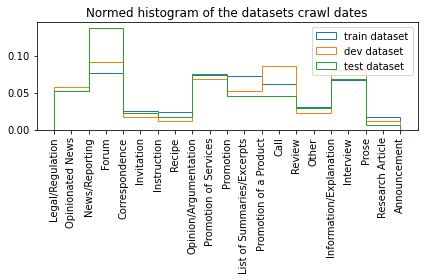

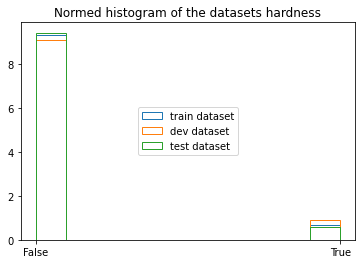

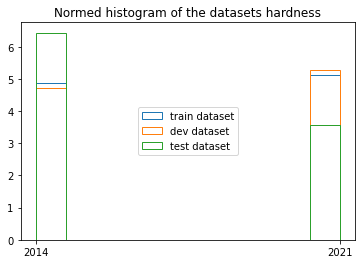

In [193]:
density = True

plt.hist(train.primary, label="train dataset", density=density, histtype="step")
plt.hist(dev.primary, label="dev dataset", density=density, histtype="step")
plt.hist(test.primary, label="test dataset", density=density, histtype="step")
plt.legend()
plt.title("Normed histogram of the datasets crawl dates")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("images/2c_primaries.png")
plt.show()



plt.hist(train.hard.apply(lambda b: str(b)), label="train dataset", density=density, histtype="step")
plt.hist(dev.hard.apply(lambda b: str(b)), label="dev dataset", density=density, histtype="step")
plt.hist(test.hard.apply(lambda b: str(b)), label="test dataset", density=density, histtype="step")
plt.legend(loc="center")
plt.title("Normed histogram of the datasets hardness")
plt.savefig("images/2c_hardness.png")
plt.show()

density = True

plt.hist(train.crawled.apply(lambda b: str(b)), label="train dataset", density=density, histtype="step")
plt.hist(dev.crawled.apply(lambda b: str(b)), label="dev dataset", density=density, histtype="step")
plt.hist(test.crawled.apply(lambda b: str(b)), label="test dataset", density=density, histtype="step")
plt.legend(loc="center")
plt.title("Normed histogram of the datasets hardness")
plt.savefig("images/2c_crawled.png")
plt.show()